In [1]:
### Imports

import copy
import pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import itertools as it
import string
from sklearn import datasets
from sklearn import svm
from sklearn import tree
from sklearn import ensemble
from sklearn import neighbors
from sklearn import neural_network
from sklearn import model_selection
from sklearn import linear_model
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
%config InlineBackend.figure_format = 'retina'

In [2]:
### Config

TRAIN_SIZE     = 0.8
MAX_DATA_SIZE  = 500
RND_SEED       = 1
FIGSIZE        = (14, 8)
CLF_DICT       = {'logreg': linear_model.LogisticRegression(),
                  'knn':    neighbors.KNeighborsClassifier(),
                  'rf':     ensemble.RandomForestClassifier(),
                  'svm':    svm.SVC(),
                  'dt':     tree.DecisionTreeClassifier(),
                  'bagdt':  ensemble.BaggingClassifier(),
                  'bstdt':  ensemble.AdaBoostClassifier()}

In [3]:
### Methods and classes

def size_info(data_dict):
    ### Size info
    print("Data sizes:")
    for data_name, data_tuple in data_dict.items():
        print("\n{}:\nX: {}\ny: {}".format(data_name, data_tuple[0].shape, data_tuple[1].shape))

def shuffle_data(data_dict, seed):
    shuffled_data_dict = dict()
    for data_name, data_tuple in data_dict.items():
        X = data_tuple[0]
        y = data_tuple[1]
        
        X_and_y = pd.concat([X, y], axis=1)

        X_and_y_shuffled = X_and_y.sample(frac=1, random_state=np.random.RandomState(seed=seed))
        
        X_shuffled = X_and_y_shuffled.iloc[:, :-1]
        y_shuffled = X_and_y_shuffled.iloc[:, -1]
    
        shuffled_data_dict[data_name] = (X_shuffled, y_shuffled)
    
    return(shuffled_data_dict)

def train_test_split_data(all_data_dict, train_size, shuffle=True, random_seed=None):
    """
    Output example for shuffled_data_dict = {'wdbc': (wdbc_X, wdbc_y)}:
    out = ({'wdbc': (wdbc_X_train, wdbc_y_train)}, {'wdbc': (wdbc_X_test, wdbc_y_test)})
    """
    
    train_data_dict = dict()
    test_data_dict  = dict()
    for data_name, data_X_y_tuple in all_data_dict.items():
        X = data_X_y_tuple[0]
        y = data_X_y_tuple[1]
        
        X_tr, X_te, y_tr, y_te = model_selection.train_test_split(
            X, y,
            train_size=train_size,
            random_state=np.random.RandomState(seed=random_seed),
            shuffle=shuffle)
        train_data_dict[data_name] = (X_tr, y_tr)
        test_data_dict[data_name]  = (X_te, y_te)
        
    return(train_data_dict, test_data_dict)

def avg_sd_across_shuffles(shuffles_scores_list):
    n_shuffles = len(shuffles_scores_list)

    shuffles_avg_scores = dict()
    shuffles_sd_scores  = dict()
    for data_name in shuffles_scores_list[0].keys():
        shuffles_avg_scores[data_name] = dict()
        shuffles_sd_scores[data_name]  = dict()
        for clf_name in shuffles_scores_list[0][data_name].keys():
            shuffles_scores = list()
            for shuffle_i in np.arange(n_shuffles):
                shuffles_scores.append(shuffles_scores_list[shuffle_i][data_name][clf_name])

            scores_mean = np.mean(shuffles_scores)
            scores_sd   = np.std(shuffles_scores)

            shuffles_avg_scores[data_name][clf_name] = scores_mean
            shuffles_sd_scores[data_name][clf_name]  = scores_sd
            
    return(shuffles_avg_scores, shuffles_sd_scores)

def avg_clf_scores_across_data(splits_shuffles_avg_scores_dict):
    """
    Mean across data
      out: {0.2: {'knn': 0.9}}
      for splits_shuffles_avg_train_scores_dict and splits_shuffles_avg_test_scores_dict
    """
    
    avg_scores_clf_dict = dict()

    for train_split, data_dict in splits_shuffles_avg_scores_dict.items():
        across_data_scores_clf_dict = dict()

        # Restructure data such that we have lists of data_scores for each clf
        for data_name, clf_dict in data_dict.items():
            for clf_name, score in clf_dict.items():
                if clf_name not in across_data_scores_clf_dict:
                    across_data_scores_clf_dict[clf_name] = [score]
                else:
                    across_data_scores_clf_dict[clf_name].append(score)

        # Now average across data for each clf
        across_data_avg_score_clf_dict = dict()
        for clf_name, across_data_scores in across_data_scores_clf_dict.items():
            across_data_avg_score_clf_dict[clf_name] = np.mean(across_data_scores_clf_dict[clf_name])

        avg_scores_clf_dict[train_split] = across_data_avg_score_clf_dict
    return(avg_scores_clf_dict)


def init_clf(clf_name, clf_dict=CLF_DICT):
    return(copy.deepcopy(clf_dict[clf_name]))

class BigLoop:
    data_dict = None
    train_splits = None
    n_shuffles = None
    cv = None
    clf_param_dict = None
    method = None
    n_jobs = None
    verbose = None
    knn_fillup = None
    n_iter = None
    
    # Results
    splits_shuffles_train_scores_dict = None
    splits_shuffles_test_scores_dict  = None
    magicml_dict                      = None
    
    def __init__(self, data_dict, clf_param_dict, train_splits, n_shuffles, cv, knn_fillup=None, method='grid_search', n_iter=None, n_jobs=None, verbose=False):
        self.data_dict = data_dict
        self.clf_param_dict = clf_param_dict
        self.train_splits = train_splits
        self.n_shuffles = n_shuffles
        self.cv = cv
        self.method = method
        self.n_iter = n_iter
        self.n_jobs = n_jobs
        self.verbose = verbose
        self.knn_fillup = knn_fillup
        
    @classmethod
    def load(cls, filename):
        with open(filename, 'rb') as f:
            return pickle.load(f)
    
    def save(self, filename):
        with open(filename, 'wb') as f:
            pickle.dump(self, f, pickle.HIGHEST_PROTOCOL)
            
    def plot_avg_scores_by_hyperparam_data_clf(self, clf_name, x_param_name, plot_train_split):
        """
        Computes average score across random shuffles for a clf by a hyperparam and plots score by hyperparam.
        """

        # Create one df with all entries, indicating shuffle index as well
        plot_df = pd.DataFrame()
        for shuffle_idx, magic_ml_shuffle in enumerate(self.magicml_dict[plot_train_split]):
            add_df = magic_ml_shuffle.scores_df[clf_name]
            add_df['shuffle_idx'] = shuffle_idx
            plot_df = pd.concat((plot_df, add_df))

        plot_df = plot_df.groupby([x_param_name, 'data_name']).mean().reset_index()
        plot_df = plot_df.drop('shuffle_idx', axis=1)

        plt.figure(figsize=FIGSIZE)
        sns_plot = sns.pointplot(x_param_name, 'scores_mean', data=plot_df, hue='data_name', markers='.')
        return(sns_plot)
    
        
    def run(self):
        self.splits_shuffles_train_scores_dict = dict()
        self.splits_shuffles_test_scores_dict  = dict()
        
        self.magicml_dict = dict()
        
        loop_iter  = 0
        loop_iters = len(TRAIN_SPLITS)*N_SHUFFLES
        for train_split in self.train_splits:
            self.magicml_dict[train_split] = list()
            
            shuffles_train_scores = list() # [{'wdbc': {'knn': (tr_acc)}} for each rnd_shuffle]
            shuffles_test_scores = list()  # [{'wdbc': {'knn': (te_acc)}} for each rnd_shuffle]
            for shuffle_i in np.arange(self.n_shuffles):
                loop_iter = loop_iter + 1
                print("\n-----------------")
                print("Loop iter {}/{}".format(loop_iter, loop_iters))

                shuffled_data_dict_i = shuffle_data(self.data_dict, seed=None)
                train_data_dict, test_data_dict = train_test_split_data(shuffled_data_dict_i,
                                                                        train_split,
                                                                        shuffle=True,
                                                                        random_seed=None)
                
                rnd_split_magic = Magic_ML(copy.deepcopy(self.clf_param_dict),
                                           knn_fillup=self.knn_fillup,
                                           cv=self.cv,
                                           n_jobs=self.n_jobs,
                                           verbose=self.verbose,
                                           method=self.method)
                
                rnd_split_magic.fit(train_data_dict, n_iter=self.n_iter)
                
                self.magicml_dict[train_split].append(rnd_split_magic)

                rnd_split_train_scores = rnd_split_magic.score(train_data_dict) # {'wdbc': {'knn': 0.8}}
                rnd_split_test_scores  = rnd_split_magic.score(test_data_dict)  # {'wdbc': {'knn': 0.8}}

                shuffles_train_scores.append(rnd_split_train_scores)
                shuffles_test_scores.append(rnd_split_test_scores)

            self.splits_shuffles_train_scores_dict[train_split] = shuffles_train_scores
            self.splits_shuffles_test_scores_dict[train_split]  = shuffles_test_scores

class Magic_ML:
    
    """
    Finds hyperparams for set of datasets and set of classifiers with specified hyperparam grids
    """
    
    clf_param_dict  = None
    cv              = None
    n_jobs          = None
    verbose         = None
    method          = None
    knn_fillup      = None
    
    # fit
    train_data_dict       = None
    
    # Randomized Search
    n_iter = None
    
    # Results
    searcher_obj_dict = None
    best_params_dict  = None
    scores_df         = None # Used for plotting
    
    # States
    is_fit            = False
    
    def __init__(self, clf_param_dict, knn_fillup=None, cv=5, n_jobs=4, verbose=False, method='grid_search'):
        self.clf_param_dict = clf_param_dict
        self.cv             = cv
        self.n_jobs         = n_jobs
        self.verbose        = verbose
        self.method         = method
        self.knn_fillup     = knn_fillup
    
    @classmethod
    def load(cls, filename):
        with open(filename, 'rb') as f:
            return pickle.load(f)
    
    def save(self, filename):
        if not self.is_fit:
            raise Exception('You probably want to fit before you save!')
            
        with open(filename, 'wb') as f:
            pickle.dump(self, f, pickle.HIGHEST_PROTOCOL)
    
    def get_plot_by_clf(self, clf_name, x_param_name, figsize=FIGSIZE):
        clf_scores_df = self.scores_df[clf_name]
        
        plt.figure(figsize=figsize)
        sns_plot = sns.pointplot(x_param_name, 'scores_mean', data=clf_scores_df, hue='data_name', markers='.')
        return(sns_plot)
    
    def create_scores_df(self):
        # Prepare score df dict
        clf_scores_df_dict = dict()
        for clf_name, param_dict in self.clf_param_dict.items():
            columns = ['data_name']
            columns.extend(list(self.clf_param_dict[clf_name].keys()))
            columns.extend(['scores_mean', 'scores_sd'])

            clf_scores_df_dict[clf_name] = pd.DataFrame(columns=columns)

        for data_name, clf_searcher_obj_dict in self.searcher_obj_dict.items():
            for clf_name, searcher_obj in clf_searcher_obj_dict.items():
                grid_scores = searcher_obj.skl_search_obj.grid_scores_

                for grid_score in grid_scores:
                    param_comb_dict = grid_score[0]
                    scores_mean = np.mean(grid_score[2])
                    scores_sd = np.std(grid_score[2])

                    row = {'data_name': data_name,
                           'scores_mean': scores_mean,
                           'scores_sd': scores_sd}

                    for param_name, param_val in param_comb_dict.items():
                        row[param_name] = param_val

                    clf_scores_df_dict[clf_name] = clf_scores_df_dict[clf_name].append(row, ignore_index = True)
        self.scores_df = clf_scores_df_dict
    
    def score(self, data_dict):
        """
        Output example for {'wdbc': {wdbc_X_te, wdbc_y_te)}:
        out = {'wdbc': {'knn': 0.8}}

        data_dict abstracts over X, y
        Returns best clf's score for each combination of dataset and clf
        """

        if not self.is_fit:
            raise Exception('You need to fit me first!')

        score_dict = dict()
        for data_name, data_X_y_tuple in data_dict.items():
            X = data_X_y_tuple[0]
            y = data_X_y_tuple[1]

            score_dict[data_name] = dict()
            for clf_name, clf_searcher_obj in self.searcher_obj_dict[data_name].items():
                skl_search_obj = clf_searcher_obj.skl_search_obj
                
                score = skl_search_obj.score(X, y)
                score_dict[data_name][clf_name] = score
                
        return(score_dict)

    def fit(self, train_data_dict, n_iter=None):
        self.train_data_dict = train_data_dict

        if self.method == 'randomized_search' and n_iter is None:
            raise Exception('You need to specify n_iter for randomized search')
        self.n_iter = n_iter

        searcher_obj_dict = dict()
        best_params_dict = dict()
        for data_name, data_tuple in self.train_data_dict.items():
            print("Fitting training dataset: {} ...".format(data_name))

            X = data_tuple[0]
            y = data_tuple[1]

            searcher_obj_dict[data_name] = dict()
            best_params_dict[data_name] = dict()
            for clf_name, param_dict in self.clf_param_dict.items():
                print("  Doing {} magic ...".format(clf_name))
                searcher_obj = ParamSearcher(X, y,
                                             clf_name,
                                             copy.deepcopy(param_dict),
                                             self.method,
                                             self.knn_fillup,
                                             self.n_jobs,
                                             self.cv,
                                             self.verbose)
                searcher_obj.search(self.n_iter)
                searcher_obj_dict[data_name][clf_name] = searcher_obj

                best_params_dict[data_name][clf_name] = searcher_obj.best_params_
        self.searcher_obj_dict = searcher_obj_dict
        self.best_params_dict = best_params_dict

        self.create_scores_df()
        self.is_fit = True

class ParamSearcher:
    
    """
    Finds hyperparams for one dataset and one classifier
    """
    
    X = None
    y = None
    clf_name = None
    param_dict = None
    method = None
    verbose = None
    n_jobs = None
    cv = None
    knn_fillup = None
    
    # Randomized Search
    n_iter = None
    
    # Results
    skl_search_obj = None
    best_params_ = None
    
    def __init__(self, X, y, clf_name, param_dict, method='grid_search', knn_fillup=None, n_jobs=4, cv=5, verbose=False):
        self.X = X
        self.y = y
        self.clf_name = clf_name
        self.param_dict = param_dict
        self.method = method
        self.n_jobs = n_jobs
        self.cv = cv
        self.verbose = verbose
        self.knn_fillup = knn_fillup
        
    def check_params(self):
        # knn n_neighbors fillup
        if self.clf_name == 'knn':
            if isinstance(self.knn_fillup, int):
                if 'n_neighbors' in self.param_dict:
                    max_n_neighbors = int(np.floor(self.X.shape[0]/self.cv)-1)
                    highest_n       = np.max(self.param_dict['n_neighbors'])
                    
                    if self.X.shape[0] > highest_n:
                        fill_range = np.unique(np.linspace(highest_n, max_n_neighbors-1, self.knn_fillup, dtype=int))
                        if len(fill_range) > 0:
                            self.param_dict['n_neighbors'] = np.concatenate((self.param_dict['n_neighbors'], fill_range))
        
        # Check for exceeded hard limits of some params
        if self.clf_name == 'knn':
            if 'n_neighbors' in self.param_dict:
                max_n_neighbors = int(np.floor(self.X.shape[0]/self.cv)-1)
                if np.any(self.param_dict['n_neighbors'] > max_n_neighbors):
                    print('ParamSearcher: knn: some n_neighbors > n_samples/cv-1. Restricting range to n_samples/cv-1.')
                    self.param_dict['n_neighbors'][self.param_dict['n_neighbors'] > max_n_neighbors] = max_n_neighbors
                    
                    # Remove duplicates
                    self.param_dict['n_neighbors'] = np.unique(self.param_dict['n_neighbors'])
        elif self.clf_name == 'rf':
            if 'max_features' in self.param_dict:
                if np.any(self.param_dict['max_features'] > self.X.shape[1]):
                    print('ParamSearcher: rf: some max_features > n_features. Restricting range to max_features.')
                    self.param_dict['max_features'][self.param_dict['max_features'] > self.X.shape[1]] = self.X.shape[1]
                    
                    # Remove duplicates
                    self.param_dict['max_features'] = np.unique(self.param_dict['max_features'])
        elif self.clf_name == 'dt':
            if 'max_features' in self.param_dict:
                if np.any(self.param_dict['max_features'] > self.X.shape[1]):
                    print('ParamSearcher: dt: some max_features > n_features. Restricting range to max_features.')
                    self.param_dict['max_features'][self.param_dict['max_features'] > self.X.shape[1]] = self.X.shape[1]
                    
                    # Remove duplicates
                    self.param_dict['max_features'] = np.unique(self.param_dict['max_features'])
                    
                    
    def search(self, n_iter=None):
        self.check_params()
        
        if self.method == 'grid_search':
            skl_search_obj = GridSearchCV(estimator  = init_clf(self.clf_name),
                                          param_grid = self.param_dict,
                                          n_jobs     = self.n_jobs,
                                          cv         = self.cv,
                                          verbose    = self.verbose)
        elif self.method == 'randomized_search':
            if n_iter is None:
                raise Exception('You need to specify n_iter for randomized search')
            self.n_iter = n_iter
            
            skl_search_obj = RandomizedSearchCV(estimator           = init_clf(self.clf_name),
                                                 param_distributions = self.param_dict,
                                                 n_iter              = n_iter,
                                                 n_jobs              = self.n_jobs,
                                                 cv                  = self.cv,
                                                 verbose             = self.verbose)
        skl_search_obj.fit(self.X, self.y)
        self.skl_search_obj = skl_search_obj
        self.best_params_ = skl_search_obj.best_params_

In [4]:
### Load data
## iris
iris_X = pd.DataFrame(datasets.load_iris()['data'])
iris_y = pd.Series(datasets.load_iris()['target'])


## wdbc
wdbc_X_and_y = pd.read_csv('data/wdbc.data', header = None).iloc[:, 1:] # drop ID, then first col = y
wdbc_y = wdbc_X_and_y.iloc[:, 0]
wdbc_X = wdbc_X_and_y.iloc[:, 1:]

wdbc_y = wdbc_y.map({'B': -1, 'M': 1}) # Transform y from (B, M) to (-1, 1)


## income
# Load, prepare, and shuffle adult income data
income_X_and_y = pd.read_csv('data/adult.data', header=None)
income_X_and_y.columns = ['age', 'workclass', 'fnlwgt', 'education', 'education-num',
                         'marital-status', 'occupation', 'relationship',
                         'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week',
                         'native-country', 'income']

# one-hot encode categorical variables
income_categorical_vars = ['workclass', 'education', 'marital-status', 'occupation',
                           'relationship', 'race', 'sex', 'native-country']
income_X_and_y_onehot = pd.DataFrame()
for var in income_categorical_vars:
    dummy_coded_var_df = pd.get_dummies(income_X_and_y[var], prefix=var)
    income_X_and_y_onehot = pd.concat([income_X_and_y_onehot, dummy_coded_var_df], axis=1)

# add remaining columns to one-hot encoded df
income_X_and_y = pd.concat([income_X_and_y_onehot,
                            income_X_and_y.loc[:, income_X_and_y.columns[
                                np.logical_not(np.in1d(income_X_and_y.columns, income_categorical_vars))]]],
                           axis=1)

income_y = income_X_and_y.loc[:, 'income']
income_X = income_X_and_y.drop('income', axis=1)

# Transform y from (<=50K, >50K) to (-1, 1)
income_y = income_y.map({' <=50K': -1, ' >50K': 1})


## Letter
letter_X_and_y = pd.read_csv('data/letter.data', header=None)
letter_X = letter_X_and_y.iloc[:, 1:]
letter_y = letter_X_and_y.iloc[:, 0]

# Transform y from A:M -> -1 and N:Z -> 1
def alph_to_cat(letter):
    if str.upper(letter) in list(string.ascii_uppercase[:13]):
        return(1)
    elif str.upper(letter) in list(string.ascii_uppercase[13:]):
        return(-1)
    
letter_y = letter_y.map(alph_to_cat)

## covtype
covtype_X_and_y = pd.read_csv('data/covtype.data')
covtype_X = covtype_X_and_y.iloc[:, :-1]
covtype_y = covtype_X_and_y.iloc[:, -1]

covtype_y = covtype_y.map({7:1}).fillna(0)



all_data_dict = {'wdbc':      (wdbc_X, wdbc_y),
                 'income':    (income_X, income_y),
                 'iris':      (iris_X, iris_y),
                 'covtype':   (covtype_X, covtype_y),
                 'letter':    (letter_X, letter_y)}

# size_info(all_data_dict)

In [5]:
### Limit dataset sizes

# Shuffle
shuffled_data_dict = shuffle_data(all_data_dict, seed=RND_SEED)

lim_data_dict = dict()
for data_name, data_tuple in shuffled_data_dict.items():
    X = data_tuple[0]
    y = data_tuple[1]
    
    assert X.shape[0] == y.shape[0]
    
    if y.shape[0] > MAX_DATA_SIZE:
        X = X.sample(MAX_DATA_SIZE, random_state=RND_SEED)
        y = y.sample(MAX_DATA_SIZE, random_state=RND_SEED)

    lim_data_dict[data_name] = (X, y)

size_info(lim_data_dict)

Data sizes:

wdbc:
X: (500, 30)
y: (500,)

income:
X: (500, 108)
y: (500,)

iris:
X: (150, 4)
y: (150,)

covtype:
X: (500, 54)
y: (500,)

letter:
X: (500, 16)
y: (500,)


# Run big loop

In [6]:
import warnings
warnings.filterwarnings("ignore")

test_data_dict = {'iris': lim_data_dict['iris'],
                  'wdbc': lim_data_dict['wdbc']}

CLF_PARAM_DICT = {'knn':    {'n_neighbors':  np.arange(1, 51)},
                  'rf':     {'n_estimators': np.array([1024]),
                             'max_features': np.array([1, 2, 4, 6, 8, 12, 16, 20])},
                  'logreg': {'C':            np.array([1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3, 1e4])},
                  'svm':    {'kernel':       ['linear', 'rbf'],
                             'C':            [1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3]},
                  'dt':     {'max_depth':    np.arange(1, 30),
                             'max_features': np.arange(1, 30)},
                  'bagdt':  {'n_estimators': np.arange(1, 30)},
                  'bstdt':  {'n_estimators': np.arange(1, 30)}}


TRAIN_SPLITS   = [0.8]
N_SHUFFLES     = 1
CV             = 2

bigloop = BigLoop(test_data_dict, CLF_PARAM_DICT, TRAIN_SPLITS, N_SHUFFLES, CV,
                  knn_fillup=5, method='grid_search')
bigloop.run()
bigloop.save('test_bigloop.pkl')


-----------------
Loop iter 1/1
Fitting training dataset: iris ...
  Doing bstdt magic ...
Fitting training dataset: wdbc ...
  Doing bstdt magic ...


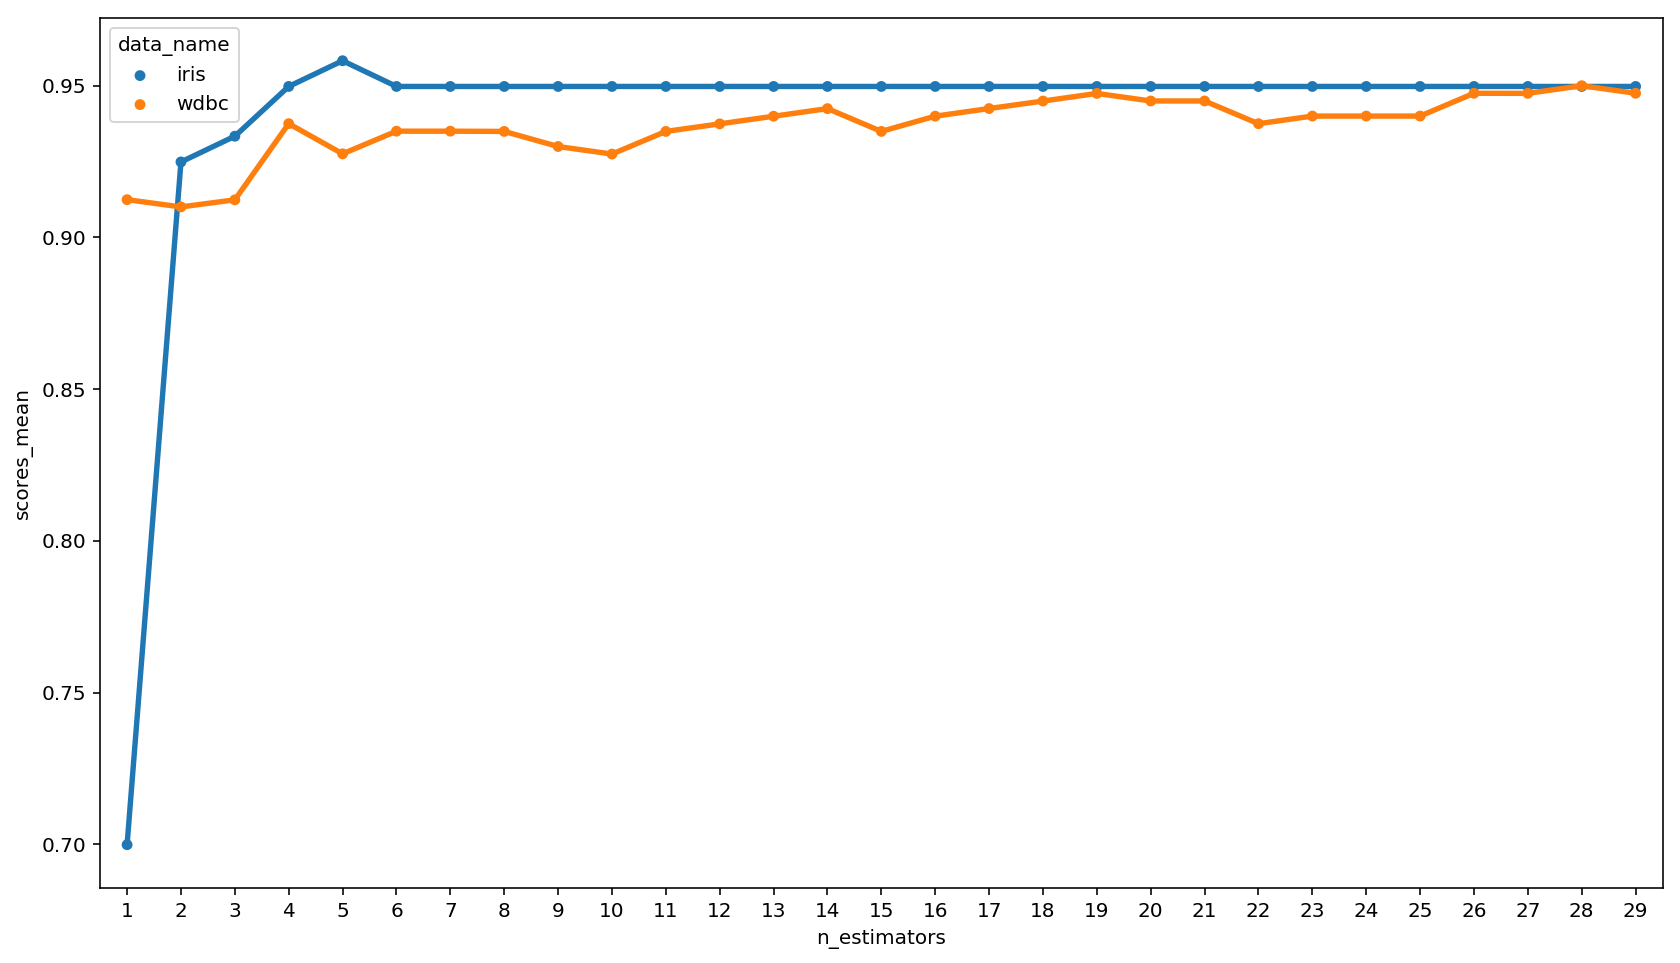

In [8]:
bigloop.plot_avg_scores_by_hyperparam_data_clf(clf_name='bstdt', plot_train_split=0.8, x_param_name='n_estimators')
plt.show()

# Big loop post processing

In [50]:
### Load results from saved big loop
bigloop_loaded = BigLoop.load('test_bigloop.pkl')
bigloop_train_scores = bigloop_loaded.splits_shuffles_train_scores_dict
bigloop_test_scores  = bigloop_loaded.splits_shuffles_test_scores_dict

In [146]:
# Mean, SD across shuffles
splits_shuffles_avg_train_scores_dict = dict()
splits_shuffles_avg_test_scores_dict = dict()

splits_shuffles_sd_train_scores_dict = dict()
splits_shuffles_sd_test_scores_dict = dict()

for train_split in bigloop_train_scores.keys():
    split_shuffles_avg_train_scores_dict, split_shuffles_sd_train_scores_dict = \
        avg_sd_across_shuffles(bigloop_train_scores[train_split])
    
    split_shuffles_avg_test_scores_dict, split_shuffles_sd_test_scores_dict = \
        avg_sd_across_shuffles(bigloop_test_scores[train_split])
        
    splits_shuffles_avg_train_scores_dict[train_split] = split_shuffles_avg_train_scores_dict
    splits_shuffles_avg_test_scores_dict[train_split]  = split_shuffles_avg_test_scores_dict
    
    splits_shuffles_sd_train_scores_dict[train_split]  = split_shuffles_sd_train_scores_dict
    splits_shuffles_sd_test_scores_dict[train_split] = split_shuffles_sd_test_scores_dict
    

In [147]:
splits_shuffles_avg_train_scores_dict

{0.8: {'iris': {'knn': 0.98750000000000004,
   'logreg': 0.97499999999999998,
   'rf': 1.0,
   'svm': 0.9916666666666667},
  'wdbc': {'knn': 0.96625000000000005,
   'logreg': 0.97499999999999998,
   'rf': 1.0,
   'svm': 0.96999999999999997}}}

In [148]:
# Average across data
avg_train_scores_by_split_clf_dict = avg_clf_scores_across_data(splits_shuffles_avg_train_scores_dict)
avg_test_scores_by_split_clf_dict  = avg_clf_scores_across_data(splits_shuffles_avg_test_scores_dict)

In [149]:
avg_train_scores_by_split_clf_dict

{0.8: {'knn': 0.97687500000000005,
  'logreg': 0.97499999999999998,
  'rf': 1.0,
  'svm': 0.98083333333333333}}

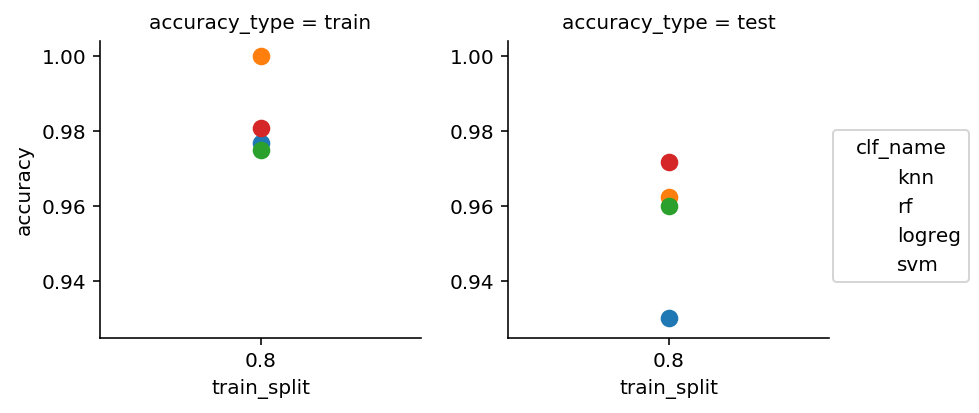

In [150]:
### Plot train/test scores avg'ed across shuffles and datasets, by clf
# Train/test accuracy averaged across random shuffles and data by clf

# Plottable df
avg_scores_by_split_cf_df = pd.DataFrame(columns = ['train_split',
                                                   'clf_name',
                                                   'accuracy_type',
                                                   'accuracy'])

for train_split, clf_score_dict in avg_train_scores_by_split_clf_dict.items():
    for clf_name, score in clf_score_dict.items():
        train_score_row = {'train_split':   train_split,
                          'clf_name':      clf_name,
                          'accuracy_type': 'train',
                          'accuracy':      avg_train_scores_by_split_clf_dict[train_split][clf_name]}
        test_score_row = {'train_split':   train_split,
                          'clf_name':      clf_name,
                          'accuracy_type': 'test',
                          'accuracy':      avg_test_scores_by_split_clf_dict[train_split][clf_name]}
        
        avg_scores_by_split_cf_df = \
                avg_scores_by_split_cf_df.append(train_score_row, ignore_index=True)
        avg_scores_by_split_cf_df = \
                avg_scores_by_split_cf_df.append(test_score_row, ignore_index=True)

            
plt.figure()
sns_plot = sns.FacetGrid(avg_scores_by_split_cf_df, col='accuracy_type', hue='clf_name')
sns_plot.map(sns.pointplot, 'train_split', 'accuracy')
sns_plot.add_legend()
plt.show()

In [151]:
### Classifier testing performance by dataset and clf, train_split=0.8
test_score_by_data_clf_df = pd.DataFrame()

for data_name, score_clf_dict in splits_shuffles_avg_test_scores_dict[0.8].items():
    data_row = {'data_name': data_name}
    for clf_name, score in score_clf_dict.items():
        data_row[clf_name] = score
    test_score_by_data_clf_df = test_score_by_data_clf_df.append(data_row, ignore_index=True)

test_score_by_data_clf_df = test_score_by_data_clf_df.set_index('data_name')
test_score_by_data_clf_df = test_score_by_data_clf_df.transpose()
test_score_by_data_clf_df

data_name,iris,wdbc
knn,0.950000,0.910
logreg,0.950000,0.970
rf,0.950000,0.975
svm,0.983333,0.960


TODO:
- Make object that hands back best classifier for dataset